# imports

In [4]:
import sys
import os
import h5py
import mattplotlib

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
import pickle
from copy import deepcopy

# plotting
import seaborn as sns
import seaborn_image as isns
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Running on Computer: [beast]
Save_dir = ./Monocular/


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


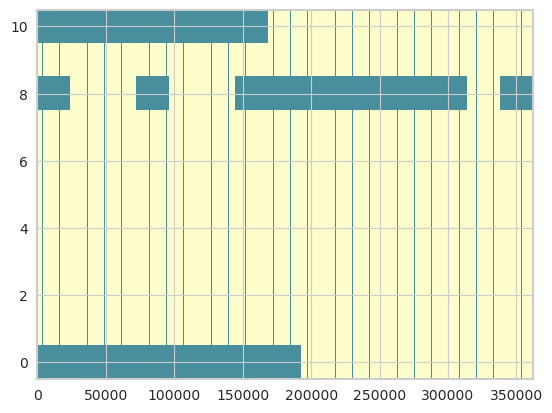

In [5]:
# load data
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

# load the model

In [132]:
with open('nim_2layer_2exp.pickle', 'rb') as f:
    model = pickle.load(f)

# create the moving bar stimulus

In [4]:
data.stim.shape, data.stim_dims

(torch.Size([362504, 360]), [1, 36, 1, 10])

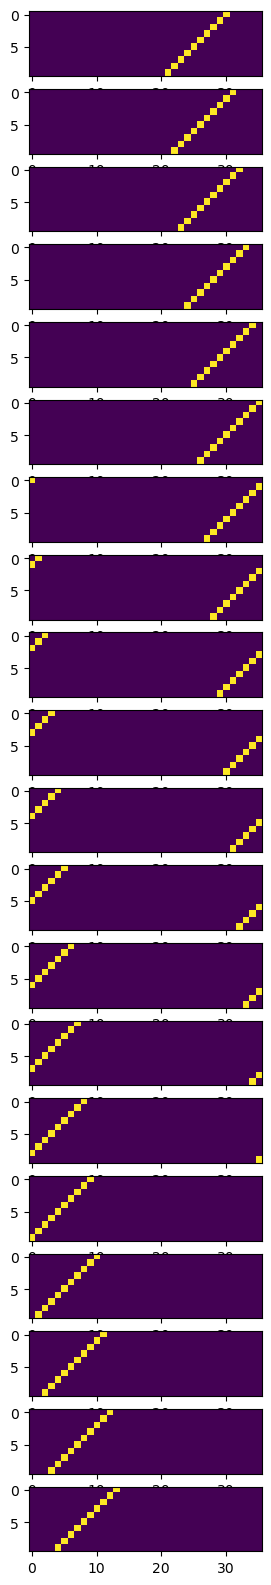

torch.Size([1000, 360])

In [75]:
num_frames = 1000

stim = torch.ones((num_frames, 36,10))
stim *= 0.5
speed = 1
f = 0
i = 0
width = stim.shape[1]
height = stim.shape[2]
while f < num_frames:
    if i >= width:
        i = 0
    for col in np.arange(0, width, speed):
        if f >= num_frames: 
            break
        if f > 0: # if we are on not the first frame
            stim[f,:,1:] = stim[f-1,:,:-1]
        stim[f, int(col), 0] = 1
        i += 1
        f += 1

num_plots = 20
plt.figure(figsize=(5,num_plots))
for i in range(num_plots):
    plt.subplot(num_plots,1,i+1)
    plt.imshow(stim[i+30].T)
plt.show()

reshaped_stims = stim.reshape((num_frames, 360))
reshaped_stims.shape

# simulate the model with the moving bar

In [76]:
m.lightmode()
figs = m.simulate_network_batch(reshaped_stims, data.stim_dims, model, figsize=(10,10), savefig_loc='nim/nim_2layer_2exp')

100%|██████████████████████████████████████████████████████| 1000/1000 [16:17<00:00,  1.02it/s]
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex -

In [110]:
import model_tester
from model_tester import *

layer1 = TestedNDNLayer()
layer1.layer_dict(input_dims=data.stim_dims, num_filters=8,
                 norm_type=1, NLtype='relu', bias=False, 
                 initialize_center = True, reg_vals={'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1} })
layer2 = TestedNDNLayer()
layer2.layer_dict(input_dims=None, num_filters=Try(8,16),
                 norm_type=1, NLtype='relu', bias=True,
                 initialize_center = True, reg_vals={'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1} })
readout_layer = TestedNDNLayer()
readout_layer.layer_dict(
    num_filters=data.NC,
    norm_type=0,
    NLtype='softplus',
    bias=True,
    initialize_center = True)

model = TestedNDN([layer1, layer2, readout_layer])

In [111]:
# jump right to shared models
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1, max_epochs=1)
adam_pars['device'] = device
adam_pars

{'optimizer_type': 'AdamW',
 'batch_size': 2000,
 'weight_decay': 0.1,
 'early_stopping': True,
 'early_stopping_patience': 4,
 'early_stopping_delta': 0.0,
 'max_iter': 10000,
 'max_epochs': 1,
 'learning_rate': 0.01,
 'betas': [0.9, 0.999],
 'amsgrad': False,
 'auto_lr': False,
 'num_workers': 0,
 'num_gpus': 1,
 'progress_bar_refresh': 20,
 'accumulated_grad_batches': 1,
 'log_activations': False,
 'device': device(type='cuda', index=1),
 'optimize_graph': False}

In [112]:
data0 = MultiDataset(datadir=datadir, filenames=['expt04'], include_MUs=False, time_embed=True, num_lags=10)
data1 = MultiDataset(datadir=datadir, filenames=['expt04', 'expt05'], include_MUs=False, time_embed=True, num_lags=10)

model.fit(Try(data0, data1), **adam_pars)

Loading expt04
  Time embedding...
Loading expt04
  Time embedding...
Loading expt05
  Time embedding...
Model: M011_NNN

GPU Available: True, GPU Used: True


Validating ver=43: 100%|████████████████████████| 35/35 [00:01<00:00, 20.95it/s, val_loss=8.93]


Done fitting
  Fit complete: 9.657071828842163 sec elapsed
Model: M011_NNN

GPU Available: True, GPU Used: True


Validating ver=44: 100%|████████████████████████| 35/35 [00:01<00:00, 20.97it/s, val_loss=9.49]


Done fitting
  Fit complete: 9.182350397109985 sec elapsed
Model: M020_NNN

GPU Available: True, GPU Used: True


Validating ver=2: 100%|█████████████████████████| 55/55 [00:02<00:00, 19.65it/s, val_loss=6.46]


Done fitting
  Fit complete: 14.412768125534058 sec elapsed
Model: M020_NNN

GPU Available: True, GPU Used: True


Validating ver=3: 100%|█████████████████████████| 55/55 [00:02<00:00, 19.60it/s, val_loss=8.25]

Done fitting
  Fit complete: 14.637529611587524 sec elapsed


In [113]:
LLs1 = model.eval_models()
LLs1

Eval models: 100%|███████████████████████████████████████████| 573/573 [00:14<00:00, 39.70it/s]


[(0,
  array([[-3.0764484e+00,  5.0032496e-02, -3.1165576e-01,  1.8042445e-02,
           4.5450807e-02, -3.7207310e+00,  8.7404251e-04, -1.3855410e-01,
          -8.5785437e+00, -8.2587919e+00, -9.6470318e+00]], dtype=float32)),
 (1,
  array([[ -8.352003  ,   0.23532224,  -7.591829  ,   0.01271129,
           -0.7204962 ,  -5.5013266 ,  -0.05758989,  -9.5543375 ,
          -10.151144  ,  -0.08193707,  -6.042321  ]], dtype=float32)),
 (2,
  array([[-7.95736313e-02,  1.11915946e-01, -5.49556732e-01,
           2.30363607e-02,  8.05791616e-02, -1.43481088e+00,
          -1.34823322e-02, -6.30989742e+00, -6.54813862e+00,
          -8.00108910e-03, -7.35603046e+00, -1.55969262e-01,
          -2.99525261e-03,  7.02023506e-04, -3.33523750e-03,
          -9.84294891e-01, -1.45020485e-01, -5.83694649e+00,
          -1.73097134e-01, -2.16024637e-01]], dtype=float32)),
 (3,
  array([[-5.920508  ,  0.15965009, -6.010898  , -0.08678329, -0.19683075,
          -0.18637109, -0.06649601, -7.183958  ,

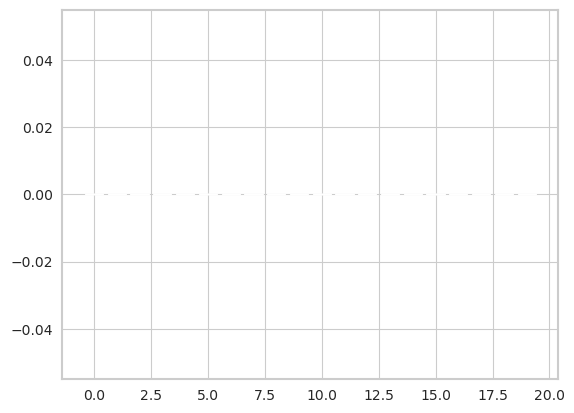

In [130]:
import seaborn as sns
import pandas as pd

plt.figure()
for i, lls in LLs1:
    ls = np.zeros(20)
    if lls[0].shape == 11: ls[:11] = lls[0]
    if lls[0].shape == 20: ls = lls[0]
    plt.bar(range(20), ls)
plt.show()

In [131]:
df = pd.DataFrame(zip(x*3, ["y"]*3+["z"]*3+["k"]*3, y+z+k), columns=["time", "kind", "data"])
plt.figure(figsize=(10, 6))
sns.barplot(x="time", hue="kind", y="data", data=df)
plt.show()

NameError: name 'x' is not defined

# test experiments

In [162]:
layer1 = NDNLayer.layer_dict(input_dims=data.stim_dims, num_filters=8,
                  norm_type=1, NLtype='relu', bias=False,
                  initialize_center = True, reg_vals={'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1} })
layer2 = NDNLayer.layer_dict(input_dims=None, num_filters=4,
                  norm_type=1, NLtype='relu', bias=True,
                  initialize_center = True, reg_vals={'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1} })
readout_layer = NDNLayer.layer_dict(
    num_filters=data.NC,
    norm_type=0,
    NLtype='softplus',
    bias=True,
    initialize_center = True)

model = NDN.NDN(layer_list=[layer1, layer2, readout_layer])
model.list_parameters()

print(LLs1[0][1])

type(device), str(device)


Network 0:
  Layer 0:
      weight: torch.Size([360, 8])
  Layer 1:
      weight: torch.Size([8, 4])
      bias: torch.Size([4])
  Layer 2:
      weight: torch.Size([4, 11])
      bias: torch.Size([11])
[[-3.0764484e+00  5.0032496e-02 -3.1165576e-01  1.8042445e-02
   4.5450807e-02 -3.7207310e+00  8.7404251e-04 -1.3855410e-01
  -8.5785437e+00 -8.2587919e+00 -9.6470318e+00]]


(torch.device, 'cuda:1')

# do stuff

In [6]:
from model import *
import experiment as exp
reload(exp)

expnameses = [['expt04']]
              #['expt04', 'expt05'],
              #['expt04', 'expt05', 'expt06'],
              #['expt04', 'expt05', 'expt06', 'expt07'],
              #['expt04', 'expt05', 'expt06', 'expt07', 'expt08'],
              #['expt04', 'expt05', 'expt06', 'expt07', 'expt08', 'expt09']]

datas = []
for expnames in expnameses:
    datas.append(MultiDataset(datadir=datadir, filenames=expnames, include_MUs=False, time_embed=True, num_lags=10))

# jump right to shared models
# TODO: try Adam vs. AdamW
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1, max_epochs=1)
adam_pars['device'] = device

from model import *

layer0 = ConvolutionalLayer().norm_type(Norm.none).NLtype(NL.relu).bias(False) \
    .initialize_center(True) \
    .reg_vals({'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}}) \
    .input_dims(datas[0].stim_dims).num_filters(8) \
    .filter_dims(21).window('hamming').padding('same').output_norm('batch')
layer1 = Layer().like(layer0).num_filters(4).input_dims(None)
layer2 = Layer().norm_type(Norm.none).NLtype(NL.relu).bias(False) \
    .initialize_center(True) \
    .reg_vals({'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}}).num_filters(8) \

network0 = Network()
network0.add_layer(layer0)
network0.add_layer(layer1)
network1 = Network().network_type(NetworkType.scaffold)
network1.add_layer(layer2)

model = Model()
model.add_network(network0)
model.add_network(network1)

NDNs = model.build(*datas)
for NDN in NDNs:
    print(NDN.list_parameters())

Loading expt04
  Time embedding...
Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([168, 4])
Network 1:
  Layer 0:
      weight: torch.Size([144, 11])
None


In [7]:
e1 = exp.Experiment('e1', model, overwrite=True)
e1.with_data(*datas)
e1.with_fit_params(adam_pars)

trials = e1.run()

==== Running 1 trials ====
==== Trial 0 ====

GPU Available: True, GPU Used: True
Epoch 1: train loss 1122.8968 val loss 1008.9968
Done fitting
  Fit complete: 13.547530889511108 sec elapsed
NDN(
  (loss_module): PoissonLoss_datafilter(
    (loss): PoissonNLLLoss()
    (lossNR): PoissonNLLLoss()
  )
  (loss): PoissonLoss_datafilter(
    (loss): PoissonNLLLoss()
    (lossNR): PoissonNLLLoss()
  )
  (val_loss): PoissonLoss_datafilter(
    (loss): PoissonNLLLoss()
    (lossNR): PoissonNLLLoss()
  )
  (networks): ModuleList(
    (0): FFnetwork(
      (layers): ModuleList(
        (0): ConvLayer(
          (NL): ReLU()
          (reg): Regularization(
            (reg_modules): ModuleList()
          )
        )
        (1): ConvLayer(
          (NL): ReLU()
          (reg): Regularization(
            (reg_modules): ModuleList()
          )
        )
      )
    )
    (1): ScaffoldNetwork(
      (layers): ModuleList(
        (0): NDNLayer(
          (NL): ReLU()
          (reg): Regulariza

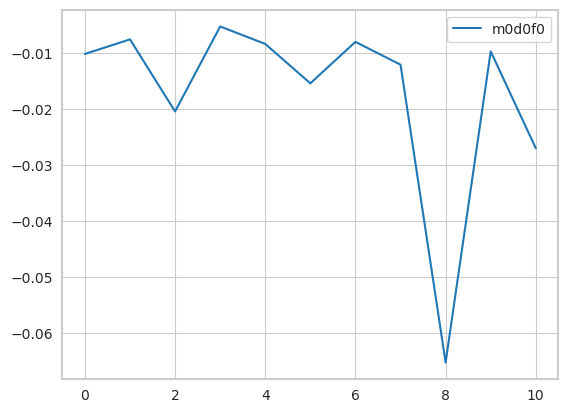

In [8]:
e1.plot_LLs()

In [298]:
from model import *

layer0 = Layer().norm_type(Norm.none).NLtype(NL.relu).bias(False) \
    .initialize_center(True) \
    .reg_vals({'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}}) \
    .input_dims(data.stim_dims).num_filters(8,2,4)

layer1 = Layer().like(layer0).num_filters(data.NC).input_dims(None)

network = Network()
network.add_layer(layer0)
network.add_layer(layer1)

model = Model()
model.add_network(network)
NDNs = model.build(data)

In [299]:
NDNs

[NDN(
   (loss_module): PoissonLoss_datafilter(
     (loss): PoissonNLLLoss()
     (lossNR): PoissonNLLLoss()
   )
   (loss): PoissonLoss_datafilter(
     (loss): PoissonNLLLoss()
     (lossNR): PoissonNLLLoss()
   )
   (val_loss): PoissonLoss_datafilter(
     (loss): PoissonNLLLoss()
     (lossNR): PoissonNLLLoss()
   )
   (networks): ModuleList(
     (0): FFnetwork(
       (layers): ModuleList(
         (0): NDNLayer(
           (NL): ReLU()
           (reg): Regularization(
             (reg_modules): ModuleList()
           )
         )
         (1): NDNLayer(
           (NL): ReLU()
           (reg): Regularization(
             (reg_modules): ModuleList()
           )
         )
       )
     )
   )
 ),
 NDN(
   (loss_module): PoissonLoss_datafilter(
     (loss): PoissonNLLLoss()
     (lossNR): PoissonNLLLoss()
   )
   (loss): PoissonLoss_datafilter(
     (loss): PoissonNLLLoss()
     (lossNR): PoissonNLLLoss()
   )
   (val_loss): PoissonLoss_datafilter(
     (loss): PoissonNLLLo